# Practical 5: Neural Network

### In this practical
1. [Resuming from practical 4](#resume)
2. [Building your first neural network model](#build)
3. [Understanding your neural network model](#viz)
4. [Finding optimal hyperparameters with GridSearchCV](#gridsearch)
5. [Feature selection](#fselect)
6. [Comparing models](#comparison)

---

### Important Changelog:
* (25/07/2017) Made tutorial notes public.

This practical introduces neural network mining in Python. Similar with previous practicals, our objective is to build a neural network to classify the lapsing donors based on their responses to the greeting card mailing campaign conducted by the national veterans' organisation. We will continue using **PVA97NK** dataset to predict **TARGETB**.

With its exotic sounding name, a neural network model is often regarded as mysterious yet powerful predictive tool. Perhaps surprisingly, the most typical form of neural network, in fact, is a natural extension of regression model. This form of neural network is called **multilayer perceptron**, which is the subject of our practical today.

<img src="resources/brain_vs_perceptron.png" width="300">
*Brain neuron vs a perceptron*

Whereas the strength of regression models is making decision in data with linear relationships, the strength of multi-layer perceptrons is their ability to go beyond linear relationships and model non-linear relationships in data.

<img src="resources/mlp.png" width="400">
*Multilayer perceptron structure*

Multilayer perceptron models were originally inspired by structure and interconnections between neurons in brain. They are often represented using network diagram instead of an equation. The basic model form arranges neurons in layers. The first layer, called the **input layer**, connects to one or more **hidden layers**, which in turn, connect to the final layer called **target/output layer**. Connections between each layer correspond to certain set of weights, which like regression model, are optimised during training process.

At the end of this practical, we would have built a number of predictive models. In practice, given a new dataset, data science professionals will build and experiment with many different models. Thus, it is important to understand how to compare these models and choose the best model. The second part of this practical guides you to assessing all of the models we have built so far - decision trees, logistic regressions and neural networks.

In cases such as the financial and health domains, performance of a predictive model is crucial. To achieve even better performance, multiple models can be combined in together to achieve higher predictive performance than individual models. This approach is called **ensemble modeling** and it will be covered in the last part of this practical.

## 1. Resuming from practical 4<a name="resume"></a>
Similar with practical 3 and 4, we will reuse the code for data preprocessing. Just as regression models, neural networks are sensitive to data on different scales, thus we will also perform standarization on the dataset:

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from dm_tools import data_prep
from sklearn.preprocessing import StandardScaler

# preprocessing step
df = data_prep()

# random state
rs = 10

# train test split
y = df['TargetB']
X = df.drop(['TargetB'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

## 2. Building your first neural network model

Start by importing your neural network from the library. In `sklearn`, neural network classifier is implemented in `MLPClassifier`, short for multilayer perceptron classifier.

In [2]:
from sklearn.neural_network import MLPClassifier

Let's train our first MLPClassifier. Initiate the model without any additional parameter (other than the random state for consistency), fit it to the training data and test its performance on test data.

In [3]:
model = MLPClassifier(random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.882890855457
Test accuracy: 0.546455609085
             precision    recall  f1-score   support

          0       0.55      0.52      0.54      1453
          1       0.54      0.57      0.56      1453

avg / total       0.55      0.55      0.55      2906

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


This default neural network performed alright, with 0.546 accuracy score on the test data. Similar with the first decision tree that we trained in practical 3, you should notice that the training accuracy is much higher than the test accuracy. This is an indication the model overfits to the training data, which we will fix through GridSearch tuning and dimensionality reduction techniques.

### 2.1. Solver and activation function

As discussed in the lecture, finding the best combination of weights in neural networks is a significant search problem. The algorithm used to find this optimal weight set is called **solver** in sklearn, and the most common one is gradient descent. Gradient descent starts with a set of randomly generated weights. In each iteration of gradient descent, predictions are made on X_train and the error value (cost) is computed. The weight set is then altered to reduce this error value. Each iteration is called an epoch. To stop gradient descent iterations, either one of **maximum iterations**, **minimum error threshold** or **convergence reached** (error is not improved over a certain number of epochs) strategies is used, with combination of max iterations and convergence being the most commonly used.

In sklearn, if the neural network does not achieve convergence before maximum iteration, it will raise a "convergence is not reached" warning message. Fortunately, our first neural network reached convergence before maximum iteration limit (default to 200). If you see the message raised, the `max_iter` hyperparameter of the neural network should be increased. However, if even with very large number of maximum iteration the neural network still fails to reach convergence, this might indicate a problem with your error computation.

The following code demonstrates the warning message raised by a MLP classifier with only 100 `max_iter`. Notice that the training accuracy is lower, as the solver has not finished optimising on training data.

In [4]:
model = MLPClassifier(max_iter=100, random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(model)

Train accuracy: 0.82197640118
Test accuracy: 0.55196145905
             precision    recall  f1-score   support

          0       0.55      0.55      0.55      1453
          1       0.55      0.55      0.55      1453

avg / total       0.55      0.55      0.55      2906

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


C:\Users\lieh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Observe the MLPClassifier object hyperparameters printed out above. You should see that the `solver` hyperparameter is set by default to **adam** (stands for adaptive moment estimation). Adam is an extension of gradient descent, designed to speed up the training process and be more computationaly efficient. Adam is the solver algorithm of choice for many deep neural networks for its efficiency and we will use adam instead of normal gradient descent here.

[A great explaination of adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

Another important hyperparameter to observe is `activation`, which refers to activation function used in hidden layers of the neural network. There are a number of options to use, including:
* **identity**: $f(x) = x$, no transformation
* **tanh**: $f(x) = {tanh}(x)$, used in lecture
* **sigmoid**: $f(x) = \frac{1}{1 + e^{h(\theta, x)}}$, used in logistic regression
* **relu - rectified linear unit**: $f(x) = max(x,0)$, default option in sklearn

Identity function will change neural network into linear model, thus it is not commonly used. In the past, tanh and sigmoid are very popular, however, recent research suggested using **relu** in neural network can produce similarly accurate result at much lower training time. Therefore, we will use relu as our activation function in this practical.

## 4. Finding optimal hyperparameter with GridSearchCV

Once we trained our first neural network, we will find the optimal hyperparameters using GridSearchCV. Neural network is harder to tune than decision trees or regression models due to relatively many type parameters and slow training process. In this practical, we will focus on tuning two parameters:
1. `hidden_layer_sizes`: It has values of tuples, and within each tuple, element i-th represent the number of neurons contained in each hidden layer.
2. `alpha`: L2 regularization parameter used in each neuron's activation function.

Start by tuning the hidden layer sizes. There is no official guideline on how many neurons we should have in each layer, but for most data mining tasks a single hidden layer with neurons no more than the number of input variables and no less than output neurons (binary classification task, hence 1) is sufficient.

> #### Deep Learning
> You might have heard of deep learning, which is process of building very complex neural networks (up to hundreds of layers and thousands of neurons, hence **deep**). Deep neural networks are typically used for complex tasks, like image recognition, Siri-like voice assistant, machine translation and self-driving tasks.

See how many input features we have by printing out the train shape.

In [5]:
print(X_train.shape)

(6780, 85)


With 85 features, we will start tuning with one hidden layer of 5 to 85 neurons, increment of 20. This might take a bit of time.

In [6]:
params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 20)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.631120943953
Test accuracy: 0.557123193393
             precision    recall  f1-score   support

          0       0.56      0.57      0.56      1453
          1       0.56      0.54      0.55      1453

avg / total       0.56      0.56      0.56      2906

{'hidden_layer_sizes': (5,)}


The output of this GridSearchCV returns 5 neurons as the optimal number of neurons in the hidden layer. From the past practicals and this output, it seems like less complex models (smaller trees, smaller feature set) tend to generalise on this dataset. Based on this information, we should tune around the lower number of neurons.

In [7]:
# new parameters
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.605457227139
Test accuracy: 0.557467309016
             precision    recall  f1-score   support

          0       0.55      0.59      0.57      1453
          1       0.56      0.53      0.54      1453

avg / total       0.56      0.56      0.56      2906

{'hidden_layer_sizes': (3,)}


We now have the optimal value for neuron count in our hidden layer. Next, we will tune the second hyperparameter, which is `alpha`. The default value for `alpha` is `0.0001`, thus we will try `alpha` values around this number.

In [8]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.606194690265
Test accuracy: 0.558499655884
             precision    recall  f1-score   support

          0       0.56      0.59      0.57      1453
          1       0.56      0.53      0.54      1453

avg / total       0.56      0.56      0.56      2906

{'alpha': 0.01, 'hidden_layer_sizes': (3,)}


The GridSearch returned a hidden layer of 3 neurons and alpha value of 0.01 as the optimal hyperparameters.

## 5. Dimensionality reduction

In this section, we will try to improve performance of the model through dimensionality reduction and transformation techniques covered last week.

### 5.1. Log transformation

Similar with logistic regression, correcting skewed distributions in variables could benefit the performance of the neural network model. We will re-use the code from previous practical to perform log transformation on the skewed GiftAvg and GiftCnt variables.

In [9]:
import numpy as np

# list columns to be transformed
columns_to_transform = ['GiftAvg36', 'GiftAvgAll', 'GiftAvgCard36', 'GiftAvgLast',
                        'GiftCnt36', 'GiftCntAll', 'GiftCntCard36', 'GiftCntCardAll']

# copy the dataframe
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)
    
# create X, y and train test data partitions
y_log = df_log['TargetB']
X_log = df_log.drop(['TargetB'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

Once the data is transformed, train and tune a MLPClassifier with GridSearchCV and see if it improves the model performance.

In [10]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.615634218289
Test accuracy: 0.568479008947
             precision    recall  f1-score   support

          0       0.58      0.50      0.54      1453
          1       0.56      0.64      0.60      1453

avg / total       0.57      0.57      0.57      2906

{'alpha': 0.01, 'hidden_layer_sizes': (5,)}


With log transformation, the MLPClassifier sees improvement in both train and test accuracy.

### 5.2. Recursive Feature Elimination

Next, we will try to reduce the feature set size using RFE. We will need a base elimination model and RFE requires type of model that assigns weight/feature importance to each feature (like regression/decision tree). Unfortunately, neural networks provide neither, thus we will try to use LogisticRegression as the base elimination model.

As the log transformation has proven to improve model performance, we will use the transformed dataset instead of the original dataset for RFE.

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train_log, y_train_log)

print(rfe.n_features_)

34


The RFE with logistic regression has selected 34 features as the best set of features. With these selected features, tune an `MLPClassifier` with the transformed data set as training data.

In [12]:
# transform log 
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_rfe, y_train_log)

print("Train accuracy:", cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", cv.score(X_test_rfe, y_test_log))

y_pred = cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

Train accuracy: 0.59587020649
Test accuracy: 0.56159669649
             precision    recall  f1-score   support

          0       0.56      0.60      0.58      1453
          1       0.57      0.52      0.54      1453

avg / total       0.56      0.56      0.56      2906

{'alpha': 1e-05, 'hidden_layer_sizes': (3,)}


The RFE selected feature set showed improvements over the original data set. However, compared with the previous best model (all features from log transformed dataset), the model performed slightly worse. This is an indication that elimination with logistic regression did not produce feature set suitable for neural network.

### 5.3. Selecting using decision tree

Lastly, we will use decision tree and feature importance produces from the model to perform feature selection. To start, we need to tune a decision tree with GridSearchCV.

In [18]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(3, 8),
          'min_samples_leaf': range(20, 61, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(3, 8), 'min_samples_leaf': range(20, 61, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
from dm_tools import analyse_feature_importance

analyse_feature_importance(cv.best_estimator_, X_log.columns)

GiftCnt36 : 0.227725130555
DemMedHomeValue : 0.151012685301
GiftAvgLast : 0.109239815857
GiftTimeLast : 0.0726940693811
DemAge : 0.0505020293148
GiftAvgCard36 : 0.0466386006863
DemPctVeterans : 0.0398307738873
GiftAvgAll : 0.0386717516844
GiftTimeFirst : 0.0381328472113
StatusCatStarAll : 0.0325337937087
GiftCntAll : 0.0318417515854
GiftCntCardAll : 0.0312619335355
PromCnt36 : 0.0275876801696
PromCntCardAll : 0.0269797831956
PromCntAll : 0.0199307489149
DemMedIncome : 0.0140041424717
PromCnt12 : 0.0131861443574
StatusCat96NK_A : 0.0118624603346
PromCntCard36 : 0.0102226654036
PromCntCard12 : 0.00614119244497


In [20]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(6780, 18)


`SelectFromModel` reduces the log transformed dataset into only 18 variables. Proceed to tune a MLPClassifier with this dataset.

In [22]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv.score(X_train_sel_model, y_train))
print("Test accuracy:", cv.score(X_test_sel_model, y_test))

y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv.best_params_)

Train accuracy: 0.594690265487
Test accuracy: 0.557811424639
             precision    recall  f1-score   support

          0       0.55      0.61      0.58      1453
          1       0.57      0.50      0.53      1453

avg / total       0.56      0.56      0.56      2906

{'alpha': 0.001, 'hidden_layer_sizes': (5,)}


Similar with RFE in the previous step, the SelectFromModel with decision tree did not manage to improve model performance too. Therefore, we will keep the log transformed model as the best performing neural network.

## 6. Comparing Models

We have learned how to perform data preprocessing, building various predictive models, tuning them and applying dimensionality reduction techniques. In a data mining project, you typically need to test numerous combinations of models and data techniques before choosing a solution to deploy. To aid with deciding between multiple solutions, we will discuss some comparing measures.

Firstly, train and tune three models of `DecisionTreeClassifier`, `LogisticRegression` and `MLPClassifier` with GridSearchCV. We will use the original feature set with no dimensionality reduction for this demonstration, but the process should not be too much different.

In [23]:
# grid search CV for decision tree
params_dt = {'criterion': ['gini'],
          'max_depth': range(2, 5),
          'min_samples_leaf': range(40, 61, 5)}

cv = GridSearchCV(param_grid=params_dt, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

dt_model = cv.best_estimator_
print(dt_model)

# grid search CV for logistic regression
params_log_reg = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params_log_reg, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

log_reg_model = cv.best_estimator_
print(log_reg_model)

# grid search CV for NN
params_nn = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv = GridSearchCV(param_grid=params_nn, estimator=MLPClassifier(max_iter=500, random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

nn_model = cv.best_estimator_
print(nn_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, v

### 6.1. Test Accuracy

The first statistic we will use to compare these three models is accuracy. We have been using accuracy to perform model validation and tuning so far. Accuracy is a great statistics when the ratio of target classes are relatively equal, like what we have in this dataset (50% donors vs 50% non-donors). In cases where the targets are not equal (e.g. in cancer detection task where most people in the dataset will not have cancer), metrics like precision/recall/F1 from `classification_report` or Cohen's kappa are preferred.

In [24]:
y_pred_dt = dt_model.predict(X_test)
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test, y_pred_nn))

Accuracy score on test for DT: 0.546455609085
Accuracy score on test for logistic regression: 0.565381968341
Accuracy score on test for NN: 0.558499655884


On test accuracy score, logistic regression performs the best, followed by decision tree and neural network.

### 6.2. ROC AUC
Another commonly used metric is receiver operating characteristic (ROC) and area under curve (AUC). ROC refers to the ability of binary classifier (like what we have here) to classify with varied discrimination threshold.

Most predictive classification models produce probability of target values on a set of inputs. `LogisticRegression` and `MLPClassifier` produces real value probabilities, while `DecisionTree` has the ratio of majority classes in each leaf node. Most of the time, discrimination threshold is cap at 0.5, which means any probability prediction above 0.5 is considered as positive (and the rest negative). For more clarity, see this code below:

In [25]:
# typical prediction
y_pred = dt_model.predict(X_test)

# probability prediction from decision tree
y_pred_proba_dt = dt_model.predict_proba(X_test)

print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
print("(Probs on zero)\t(probs on one)\t(prediction made)")
# print top 10
for i in range(20):
    print(y_pred_proba_dt[i][0], '\t', y_pred_proba_dt[i][1], '\t', y_pred[i])

Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.
(Probs on zero)	(probs on one)	(prediction made)
0.341238471673 	 0.658761528327 	 1
0.468456375839 	 0.531543624161 	 1
0.483870967742 	 0.516129032258 	 1
0.483870967742 	 0.516129032258 	 1
0.468456375839 	 0.531543624161 	 1
0.483870967742 	 0.516129032258 	 1
0.468456375839 	 0.531543624161 	 1
0.468456375839 	 0.531543624161 	 1
0.468456375839 	 0.531543624161 	 1
0.646887159533 	 0.353112840467 	 0
0.483870967742 	 0.516129032258 	 1
0.646887159533 	 0.353112840467 	 0
0.468456375839 	 0.531543624161 	 1
0.257142857143 	 0.742857142857 	 1
0.483870967742 	 0.516129032258 	 1
0.483870967742 	 0.516129032258 	 1
0.257142857143 	 0.742857142857 	 1
0.483870967742 	 0.516129032258 	 1
0.495652173913 	 0.504347826087 	 1
0.341238471673 	 0.658761528327 	 1


With this concept in mind, ROC AUC score aims to find the best model under varied threshold. To compute our ROC AUC score, use the code below.

In [26]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

ROC index on test for DT: 0.575132305707
ROC index on test for logistic regression: 0.592773145624
ROC index on test for NN: 0.585721262083


`LogisticRegression` produces the best ROC score. This means on varied discrimination threshold, this LogReg model performs better compared to the other two models.

ROC score only tells one side of the story, however. Typically, instead of ROC score, we plot a curve to show the performance of the model on different threshold values. The curve should look something like this, and the closer the curve is to top left corner, the better the model is.

![ROC Curve](http://gim.unmc.edu/dxtests/roccomp.jpg)

Let's plot ROC curve for our models. Firstly, we need to find the false positive rate, true positive rate and thresholds used for each models. We can get it from the `roc_curve` function.

In [27]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

Once we have these scores, plot them using `matplotlib`'s pyplot.

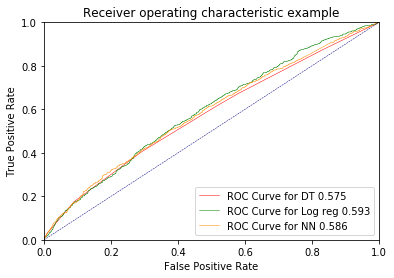

In [28]:
import matplotlib.pyplot as plt

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Here, you can see the curve for different models. `LogisticRegression` again has the largest curve area compared to the other two models. Thus, all three statistics that we used collectively agreed on `LogisticRegression` being the best performing model overall.

While statistics are vital, in a real project, performance is not always the priority. Some of the other aspects used to consider a best model are:
1. **Interpretability**: how well humans can understand decision making process in the model. Decision trees and regressions to some extent are excellent at this, while neural networks are much less interpretable.
2. **Speed**: how well can the model train and predict on large amount of data. Again decision trees and regressions are relatively fast, while neural networks take a while to train.
3. **Adaptability**: in cases where the model is deployed in a changing environment (e.g. predicting website user behaviour), the model needs to adapt to the changing data. Neural networks are great for this as they can be trained using "online training", while decision trees are not so great.

## 7. Ensemble Modeling

Ensemble modeling is a supervised, predictive modeling method that combines predictions from multiple models to produce a stronger model. Ensemble models are typically more accurate and more robust than the individual models they are built on. Typically, the individual models consist of different classes (e.g. combining decision tree and logistic regression) or they are trained on different subsets of the data (e.g. combining 2 decision trees, each trained on one half of training data).

There are three major techniques in performing ensemble:
1. **Bagging**: In bagging method, predictions from each models are combined through voting/averaging process. An example of bagging model is **Random Forest**, which is a bagging-based model consisted of many simple decision trees trained on random subsets of the data.
2. **Boosting**: Boosting method combines models through sequential learning. The first model is learned and evaluated on the whole dataset. Each classes of misclassified training examples are then given higher priority/weight. Another model will be built to predict the misclassified classes correctly. This process will be continued until a set limit is reached (commonly number of models or accuracy improvement convergence). The most well known boosting models are **Gradient Boosting** and **AdaBoost**.
3. **Stacking**: Stacking is similar to bagging. Instead of using simple voting/averaging process, stacking ensemble build another model to assign weights to predictions of each individual model.

[A great introduction to ensemble learning and why it works very well](https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/)

In this practical, we will build a simple voting-based bagging model to combine three models we built in section 6. Start by importing the `VotingClassifier` from `sklearn.ensemble`. After that, initialise the voting classifier as follows.

In [35]:
# import the model
from sklearn.ensemble import VotingClassifier

# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')

There are two possible values for the `voting` hyperparameter, **hard voting** and **soft voting**. With hard voting, the predictions are made using the majority predicted value, while soft voting computes predictions based on softmax value of predicted probabilities. With well-calibrated models (we did calibration through GridSearchCV), `sklearn` recommends soft voting.

Fit the voting model to the training data. After that, evaluate the accuracy on test data.

In [39]:
# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

Ensemble train accuracy: 0.605457227139
Ensemble test accuracy: 0.567102546456
ROC score of voting classifier: 0.595562068938


The ensemble method managed to produce higher test accuracy and ROC score compared to the three individual models.

## End Notes and Next Practical

This practical, we learned how to build, tune and explore the structure of neural network models. We explored dimensionality reduction and transformation techniques to reduce the size of the feature set and improve performance of our neural network model. In addition, numerous statistics are used to compare end-to-end performance of all models we have built so far. Lastly, we built a voting, bagging-based ensemble model from three smaller models.

Next week, we will have a drop-in help session where you focus on the assignment and ask your tutor questions regarding it.